#**ZEE5 RECOMMENDATION SYSTEM**

**Problem Statement:**

Develop a personalized movie recommendation system for the ZEE5 platform. This system should leverage user ratings and the preferences of similar users to deliver tailored movie suggestions, thereby enhancing the user experience. The goal is to increase user engagement and satisfaction by providing relevant and appealing movie recommendations based on different  techniques.

**RATINGS FILE DESCRIPTION**

===================================================================
UserID::MovieID::Rating::Timestamp

UserIDs range between 1 and 6040

MovieIDs range between 1 and 3952

Ratings are made on a 5-star scale (whole-star ratings only)

Timestamp is represented in seconds

Each user has at least 20 ratings

**USERS FILE DESCRIPTION**

==================================================================
UserID::Gender::Age::Occupation::Zip-code

Gender is denoted by a "M" for male and "F" for female

Age is chosen from the following ranges:

1: "Under 18",18: "18-24",25: "25-34",35: "35-44",45: "45-49",50: "50-55",56: "56+"

Occupation is chosen from the following choices:

0: "other" or not specified,1: "academic/educator",2: "artist",3: "clerical/admin",4: "college/grad student",5: "customer service",6: "doctor/health care",7: "executive/managerial",8: "farmer",9: "homemaker",10: "K-12 student",11: "lawyer",12: "programmer",13: "retired",14: "sales/marketing",15: "scientist",16: "self-employed",17: "technician/engineer"
,18: "tradesman/craftsman",19: "unemployed",20: "writer"

**MOVIES FILE DESCRIPTION**

=========================================================================
MovieID::Title::Genres

Titles are identical to titles provided by the IMDB (including year of release)

Genres are pipe-separated and are selected from the following genres:

Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western

**What is a Recommender System?**

A recommender engine, or a recommendation system is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item.

**Types of Recommender Systems -**

Recommender systems usually make use of either or both Collaborative Filtering and Content-based Filtering techniques.

**1)Collaborative Filtering:**

Collaborative filtering is based on the assumption that people who agreed in the past will agree in the future, and that they will like similar kinds of items as they liked in the past. The system generates recommendations using only information about rating profiles for different users or items. By locating peer users/items with a rating history similar to the current user or item, they generate recommendations using this neighborhood.

**2)Content-based Filtering:**

Content-based filtering methods are based on a description of the item and a profile of the user's preferences. These methods are best suited to situations where there is known data on an item (name, location, description, etc.), but not on the user. Content-based recommenders treat recommendation as a user-specific classification problem and learn a classifier for the user's likes and dislikes based on an item's features.

In [2]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading data**

In [4]:
movies = pd.read_csv('/content/drive/MyDrive/zee-movies.dat', delimiter='::',engine='python',encoding='ISO-8859-1')
movies=movies.rename(columns={'Movie ID':'MovieID'})
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings = pd.read_csv('/content/drive/MyDrive/zee-ratings.dat', delimiter='::',engine='python',encoding='ISO-8859-1')
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
users = pd.read_csv('/content/drive/MyDrive/zee-users.dat', delimiter='::',engine='python',encoding='ISO-8859-1')
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


# **Data Cleaning & Processing**

In [7]:
#Split genres and explode into multiple rows
movies['Genres'] = movies['Genres'].str.split('|')
movies = movies.explode('Genres')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children's
0,1,Toy Story (1995),Comedy
1,2,Jumanji (1995),Adventure
1,2,Jumanji (1995),Children's


In [8]:
#extracting year from title
movies['Release_Year']=movies['Title'].str.extract('.*\((.*)\).*',expand=True)
movies['Title']=movies['Title'].str.split('(').str[0]
#converting all values to lower case
movies[['Title', 'Genres']] = movies[['Title', 'Genres']].apply(lambda x: x.str.lower())

In [9]:
#computing avgerage_rating and rating_cout of each user and also extracting hour from timestamp
from datetime import datetime
ratings['avg_rating']=ratings.groupby('MovieID')['Rating'].transform('mean').round()
ratings['rating_count']=ratings.groupby('MovieID')['Rating'].transform('count')
ratings['hour']= ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)
ratings.drop(['Timestamp'],axis=1,inplace=True)
ratings.head()

,UserID,MovieID,Rating,avg_rating,rating_count,hour
0,1,1193,5,4.0,1725,22
1,1,661,3,3.0,525,22
2,1,914,3,4.0,636,22
3,1,3408,4,4.0,1315,22
4,1,2355,5,4.0,1703,23


In [10]:
#replacing age and occupation column in bin format in users table
age_mapping = {'1': "Under 18",
               '18': "18-24",
               '25': "25-34",
               '35': "35-44",
               '45': "45-49",
               '50': "50-55",
               '56': "56 Above"}

users['Age'] = users['Age'].astype(str).map(age_mapping).fillna(users['Age'])
occupation_mapping = {'0': "other",
                     '1': "academic/educator",
                     '2': "artist",
                     '3': "clerical/admin",
                     '4': "college/grad student",
                     '5': "customer service",
                     '6': "doctor/health care",
                     '7': "executive/managerial",
                     '8': "farmer",
                     '9': "homemaker",
                     '10': "k-12 student",
                     '11': "lawyer",
                     '12': "programmer",
                     '13': "retired",
                     '14': "sales/marketing",
                     '15': "scientist",
                     '16': "self-employed",
                     '17': "technician/engineer",
                     '18': "tradesman/craftsman",
                     '19': "unemployed",
                     '20': "writer"}

users['Occupation'] = users['Occupation'].astype(str).map(occupation_mapping).fillna(users['Occupation'])
users.head(2)


,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,k-12 student,48067
1,2,M,56 Above,self-employed,70072


In [11]:
#getting the shape of all three tabels
print('Movies:',movies.shape)
print('Ratings:',ratings.shape)
print('Users:',users.shape)

Movies: (6408, 4)
Ratings: (1000209, 6)
Users: (6040, 5)


# **EDA**

In [12]:
#merging all three tabels
df = movies.merge(ratings,on='MovieID',how='inner').merge(users,on='UserID',how='inner')
df.head()

,MovieID,Title,Genres,Release_Year,UserID,Rating,avg_rating,rating_count,hour,Gender,Age,Occupation,Zip-code
0,1,toy story,animation,1995,1,5,4.0,2077,23,F,Under 18,k-12 student,48067
1,1,toy story,children's,1995,1,5,4.0,2077,23,F,Under 18,k-12 student,48067
2,1,toy story,comedy,1995,1,5,4.0,2077,23,F,Under 18,k-12 student,48067
3,48,pocahontas,animation,1995,1,5,3.0,382,23,F,Under 18,k-12 student,48067
4,48,pocahontas,children's,1995,1,5,3.0,382,23,F,Under 18,k-12 student,48067


In [13]:
df.shape

(2101815, 13)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101815 entries, 0 to 2101814
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   MovieID       int64  
 1   Title         object 
 2   Genres        object 
 3   Release_Year  object 
 4   UserID        int64  
 5   Rating        int64  
 6   avg_rating    float64
 7   rating_count  int64  
 8   hour          int64  
 9   Gender        object 
 10  Age           object 
 11  Occupation    object 
 12  Zip-code      object 
dtypes: float64(1), int64(5), object(7)
memory usage: 208.5+ MB


In [15]:
df.describe()

,MovieID,UserID,Rating,avg_rating,rating_count,hour
count,2.101815e+06,2.101815e+06,2.101815e+06,2.101815e+06,2.101815e+06,2.101815e+06
mean,1.777774e+03,3.026197e+03,3.582593e+00,3.573234e+00,9.275820e+02,1.191088e+01
std,1.069834e+03,1.731014e+03,1.116710e+00,5.915704e-01,7.114270e+02,7.904367e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,9.420000e+02,1.505000e+03,3.000000e+00,3.000000e+00,3.810000e+02,4.000000e+00
50%,1.645000e+03,3.075000e+03,4.000000e+00,4.000000e+00,7.510000e+02,1.400000e+01
75%,2.640000e+03,4.478000e+03,4.000000e+00,4.000000e+00,1.254000e+03,1.900000e+01
max,3.952000e+03,6.040000e+03,5.000000e+00,5.000000e+00,3.428000e+03,2.300000e+01


In [16]:
#checking for null values
df.isna().sum()

MovieID         0
Title           0
Genres          0
Release_Year    0
UserID          0
Rating          0
avg_rating      0
rating_count    0
hour            0
Gender          0
Age             0
Occupation      0
Zip-code        0
dtype: int64

In [17]:
import re
# Function to clean movie titles
def clean_title(title):
    # Remove special characters and numbers using regular expressions
    cleaned_title = re.sub(r'[^A-Za-z0-9\s]', '', title)
    # Convert to lowercase
    cleaned_title = cleaned_title.lower()
    # Remove leading and trailing whitespace
    cleaned_title = cleaned_title.strip()
    return cleaned_title

# Apply the cleaning function to the movie_title column
df['Title'] = df['Title'].apply(clean_title)


**Top 10 Movies and Genres by Average Rating and rating count**

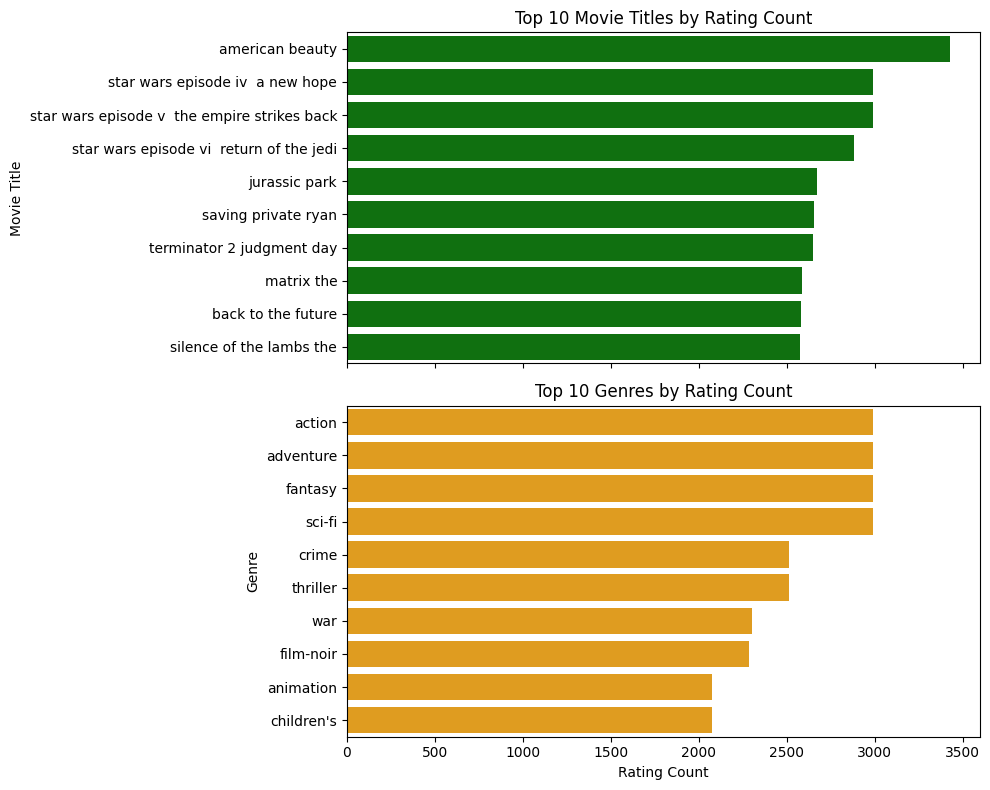

In [18]:
# Extract top 10 unique movie titles by rating count
top_titles_count = df.drop_duplicates(subset=['Title']).nlargest(10, 'rating_count')

# Extract top 10 unique genres by rating count
top_genres_count = df.drop_duplicates(subset=['Genres']).nlargest(10, 'rating_count')

# Set up the matplotlib figure
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot top 10 movie titles by rating count
sns.barplot(x='rating_count', y='Title', data=top_titles_count, ax=axs[0], color='green')
axs[0].set_title('Top 10 Movie Titles by Rating Count')
axs[0].set_xlabel('Rating Count')
axs[0].set_ylabel('Movie Title')

# Plot top 10 genres by rating count
sns.barplot(x='rating_count', y='Genres', data=top_genres_count, ax=axs[1], color='orange')
axs[1].set_title('Top 10 Genres by Rating Count')
axs[1].set_xlabel('Rating Count')
axs[1].set_ylabel('Genre')

plt.tight_layout()
plt.show()

--Here we can see top rating count of movies and genres

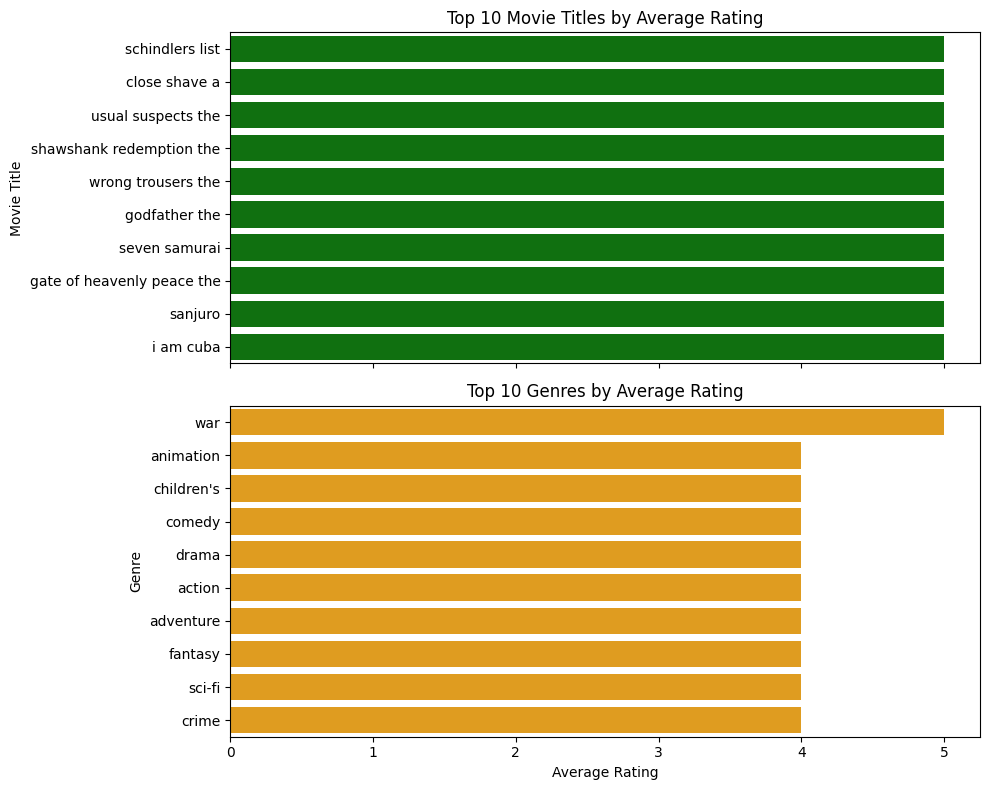

In [19]:
# Extract top 10 unique movie titles by average rating
top_titles = df.drop_duplicates(subset=['Title']).nlargest(10, 'avg_rating')
# Extract top 10 unique genres
top_genres = df.drop_duplicates(subset=['Genres']).nlargest(10, 'avg_rating')

# Set up the matplotlib figure
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot top 10 movie titles by average rating
sns.barplot(x='avg_rating', y='Title', data=top_titles, ax=axs[0],color='green')
axs[0].set_title('Top 10 Movie Titles by Average Rating')
axs[0].set_xlabel('Average Rating')
axs[0].set_ylabel('Movie Title')

# Plot top 10 genres by average rating
sns.barplot(x='avg_rating', y='Genres', data=top_genres, ax=axs[1],color='orange')
axs[1].set_title('Top 10 Genres by Average Rating')
axs[1].set_xlabel('Average Rating')
axs[1].set_ylabel('Genre')

plt.tight_layout()
plt.show()

**Number of movies released per year and dustribution of age**

Text(0, 0.5, 'Number of Movies')

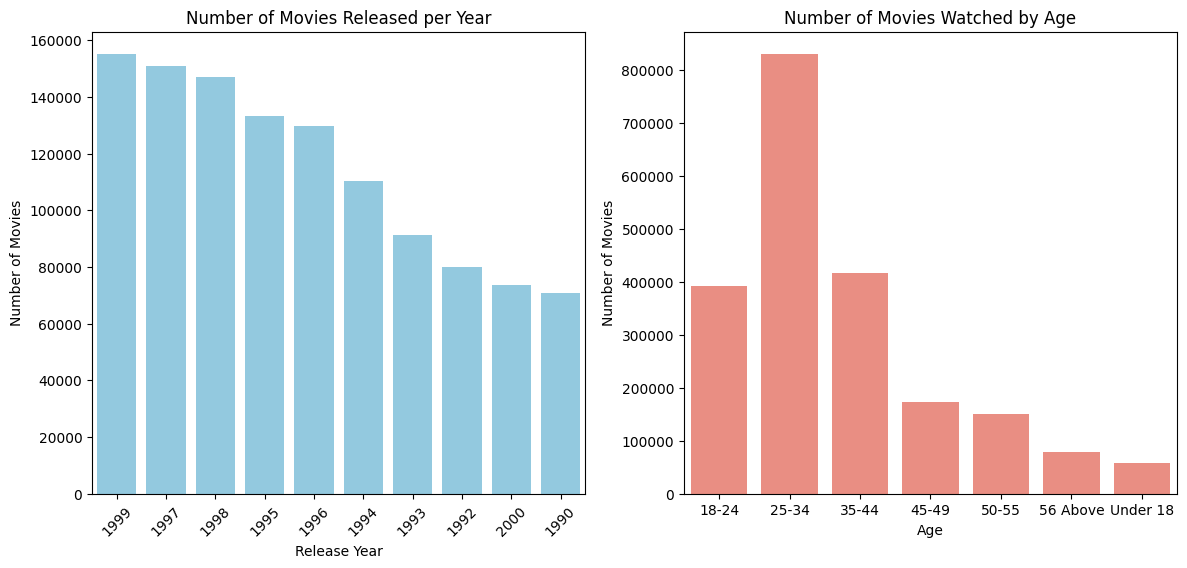

In [20]:
# Count the number of movies released per year
movie_counts = df.groupby('Release_Year')['MovieID'].count().sort_values(ascending=False).head(10)

# Count the number of movies watched by age
age_counts = df.groupby('Age')['MovieID'].count().sort_index()

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Release_year vs movie_count
sns.barplot(x=movie_counts.index, y=movie_counts.values, color='skyblue', ax=axes[0])
axes[0].set_title('Number of Movies Released per Year')
axes[0].set_xlabel('Release Year')
axes[0].set_ylabel('Number of Movies')
axes[0].tick_params(axis='x', rotation=45)

# Plot Age vs movie_count
sns.barplot(x=age_counts.index, y=age_counts.values, color='salmon', ax=axes[1])
axes[1].set_title('Number of Movies Watched by Age')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Number of Movies')


--From above we can see most movies are released in 1990-2000

--25-34 age group watched and rated more movies

**Distribution of Gender**

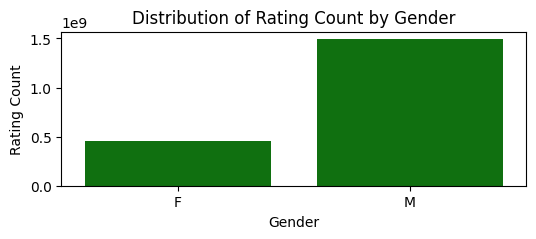

In [21]:
#plotting ditribution of rating count of gender
gender_count=df.groupby('Gender')['rating_count'].sum()
plt.figure(figsize=(6, 2))
sns.barplot(x=gender_count.index,y=gender_count.values,color='green')
plt.title('Distribution of Rating Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Rating Count')
plt.show()

--So from above males are given more ratings compared to females

**Top 5 Occupations**

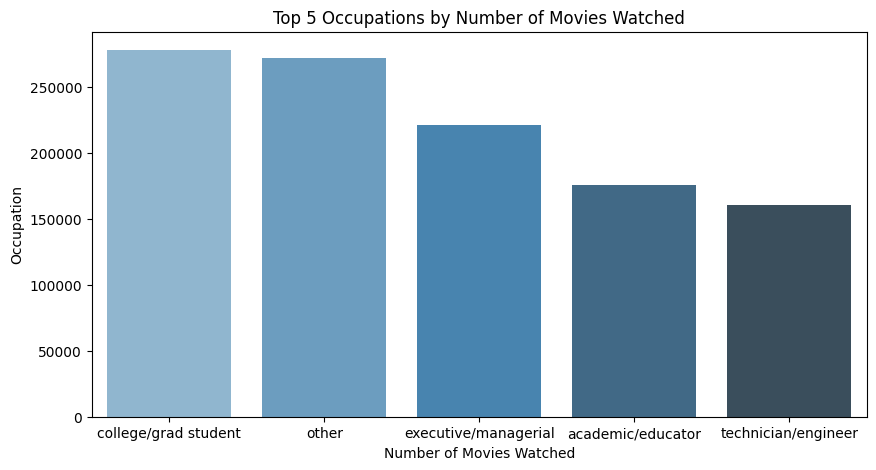

In [22]:
# Group by occupation and count the number of movies watched
top_occupations = df.groupby('Occupation')['MovieID'].count().sort_values(ascending=False).head(5)
plt.figure(figsize=(10, 5))
# Plot top 5 occupations based on the number of movies watchedplt.subplot(1, 2, 2)
sns.barplot(y=top_occupations.values,x=top_occupations.index, palette='Blues_d')
plt.title('Top 5 Occupations by Number of Movies Watched')
plt.xlabel('Number of Movies Watched')
plt.ylabel('Occupation')
plt.show()


--From above we can see college/graduate student match more movies

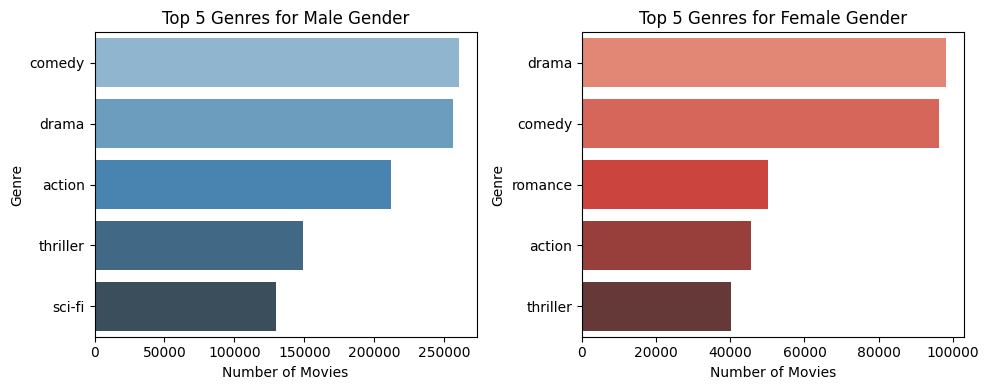

In [23]:
# Group by gender and count the occurrences of each genre
genre_counts_by_gender = df.groupby('Gender')['Genres'].value_counts()

# Extract the top 5 genres for each gender
top5_genres_male = genre_counts_by_gender.loc['M'].nlargest(5)
top5_genres_female = genre_counts_by_gender.loc['F'].nlargest(5)

# Plot top 5 genres for male and female genders side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot top 5 genres for male gender
sns.barplot(x=top5_genres_male.values, y=top5_genres_male.index, ax=axes[0], orient='h', palette='Blues_d')
axes[0].set_title('Top 5 Genres for Male Gender')
axes[0].set_xlabel('Number of Movies')
axes[0].set_ylabel('Genre')

# Plot top 5 genres for female gender
sns.barplot(x=top5_genres_female.values, y=top5_genres_female.index, ax=axes[1], orient='h', palette='Reds_d')
axes[1].set_title('Top 5 Genres for Female Gender')
axes[1].set_xlabel('Number of Movies')
axes[1].set_ylabel('Genre')

plt.tight_layout()
plt.show()

---From above we can see both males and females are intrested to see drama,comedy,action,thriller.Females are intrested to watch romance movies also

**Top 5 Hours with Most Movies by Genre**

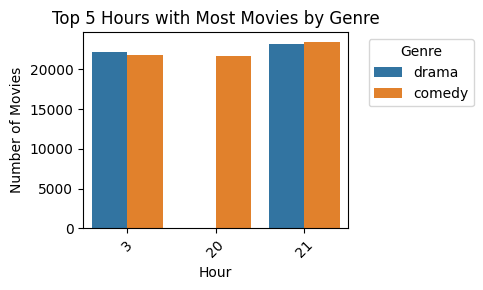

In [24]:
# Group by hour and count the occurrences of each genre for each hour
top_hours = df.groupby('hour')['Genres'].value_counts().nlargest(5).reset_index()

# Set up the matplotlib figure
plt.figure(figsize=(5, 3))

# Plot the top 5 hours along with their corresponding genres
sns.barplot(x='hour', y='count', hue='Genres', data=top_hours)
plt.title('Top 5 Hours with Most Movies by Genre')
plt.xlabel('Hour')
plt.ylabel('Number of Movies')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

--From above we can see drama and comedy movies are watched more

--Top hours watched are 3,20,21

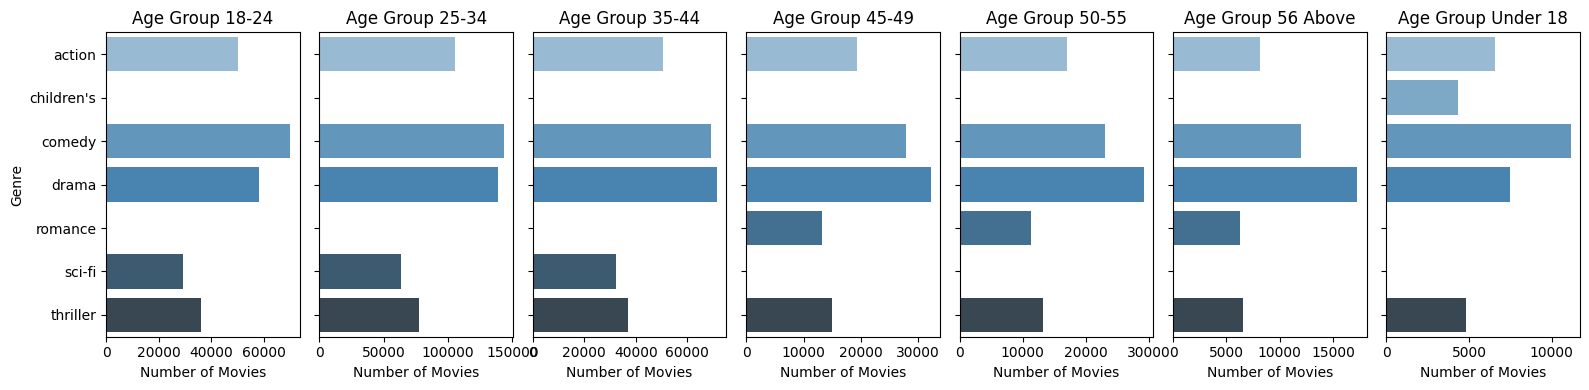

In [25]:
# Group by age and count the occurrences of each genre
genre_counts_by_age = df.groupby('Age')['Genres'].value_counts().unstack(fill_value=0)

# Get the top 10 genres for each age group
top10_genres_by_age = genre_counts_by_age.apply(lambda x: x.sort_values(ascending=False).head(5), axis=1)

# Plot top 10 genres for each age group side by side
fig, axes = plt.subplots(nrows=1, ncols=len(top10_genres_by_age), figsize=(16, 4), sharey=True)

for idx, (age, top_genres) in enumerate(top10_genres_by_age.iterrows()):
    sns.barplot(x=top_genres.values, y=top_genres.index, ax=axes[idx], palette='Blues_d')
    axes[idx].set_title(f'Age Group {age}')
    axes[idx].set_xlabel('Number of Movies')
    axes[idx].set_ylabel('Genre')

plt.tight_layout()
plt.show()

--From above plot we can see different age groups movie intrests based on genre

**Checking Frequency of Ratings and its counts**

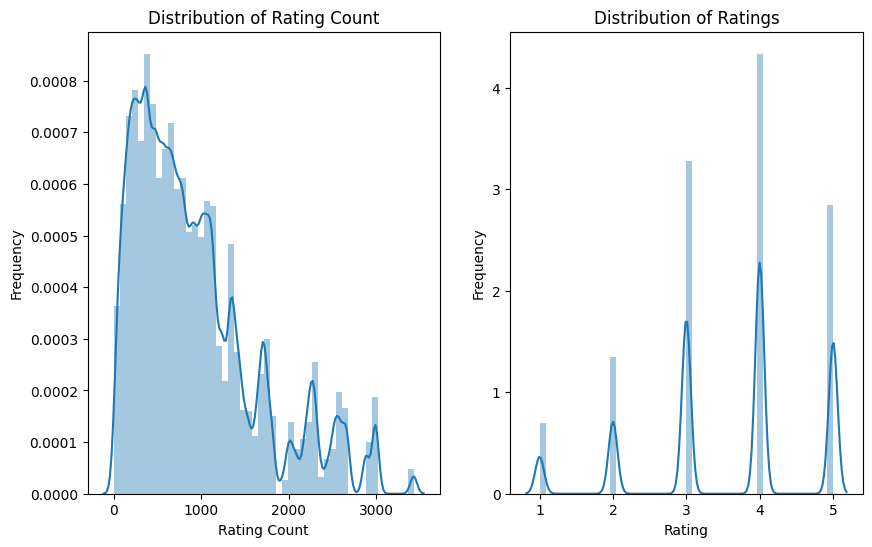

In [26]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
sns.distplot(df['rating_count'])
plt.title('Distribution of Rating Count')
plt.xlabel('Rating Count')
plt.ylabel('Frequency')
plt.subplot(1,2,2)
sns.distplot(df['Rating'])
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

--Highest ratings are 3 and 4

# **RECOMMENDATION SYSTEM**

**Creating a pivot table of movie titles & user id**

In [27]:
# Pivot the DataFrame
user_item_matrix = df.pivot_table(index='UserID', columns='Title', values='Rating')
# Fill NaN values with 0
user_item_matrix.fillna(0, inplace=True)
user_item_matrix.head()

Title,10 things i hate about you,1000000 duck,101 dalmatians,12 angry men,13th warrior the,187,1900,2 days in the valley,20 dates,200 cigarettes,...,young guns ii,young poisoners handbook the,young sherlock holmes,your friends and neighbors,youve got mail,zachariah,zed two noughts a,zero effect,zero kelvin,zeus and roxanne
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **COLLABORATIVE FILTERING**

**Item-based approach and Pearson Correlation**

In [28]:
#Recommending top 5 movies
movie_name = input("Enter a movie name: ")
movie_rating = user_item_matrix[movie_name]
similar_movies = user_item_matrix.corrwith(movie_rating)
sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True)
sim_df.iloc[1: , :].head()

Enter a movie name: liar liar


,Correlation
Title,
mrs doubtfire,0.499927
dumb dumber,0.459601
ace ventura pet detective,0.458654
home alone,0.455967
wedding singer the,0.429222


**Cosine Similarity-item similarity matrix**

In [29]:
#item-simillairty
from sklearn.metrics.pairwise import cosine_similarity
item_simillarity = cosine_similarity(user_item_matrix.T)
# Convert similarity matrix to DataFrame for easier manipulation
item_simillarity_df=pd.DataFrame(item_simillarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)
item_simillarity_df.head()

Title,10 things i hate about you,1000000 duck,101 dalmatians,12 angry men,13th warrior the,187,1900,2 days in the valley,20 dates,200 cigarettes,...,young guns ii,young poisoners handbook the,young sherlock holmes,your friends and neighbors,youve got mail,zachariah,zed two noughts a,zero effect,zero kelvin,zeus and roxanne
Title,,,,,,,,,,,,,,,,,,,,,
10 things i hate about you,1.000000,0.058619,0.215418,0.152429,0.268432,0.068144,0.000000,0.157480,0.143820,0.197267,...,0.175014,0.066803,0.141150,0.077960,0.295243,0.000000,0.012702,0.175771,0.000000,0.058708
1000000 duck,0.058619,1.000000,0.189843,0.094785,0.058418,0.028171,0.000000,0.021295,0.016918,0.089850,...,0.062749,0.038725,0.076474,0.044074,0.096464,0.000000,0.045280,0.039395,0.000000,0.120242
101 dalmatians,0.215418,0.189843,1.000000,0.235094,0.198080,0.089279,0.000000,0.188914,0.052619,0.191341,...,0.180836,0.089460,0.220065,0.119524,0.311154,0.000000,0.042295,0.157313,0.033120,0.089840
12 angry men,0.152429,0.094785,0.235094,1.000000,0.145423,0.087115,0.000000,0.148649,0.083810,0.081814,...,0.104518,0.084827,0.161800,0.116361,0.170438,0.000000,0.039344,0.133061,0.036867,0.058692
13th warrior the,0.268432,0.058418,0.198080,0.145423,1.000000,0.122239,0.009048,0.191032,0.096184,0.109083,...,0.240781,0.056625,0.205236,0.056202,0.183878,0.020193,0.041324,0.156505,0.034797,0.034623


In [30]:
def get_movie_recommendations(movie, num_recommendations=5):
    similarity_scores = item_simillarity_df[movie]
    similar_movies = similarity_scores.sort_values(ascending=False)[1:num_recommendations+1]
    return similar_movies

# Example usage
get_movie_recommendations('american beauty', num_recommendations=5)

Title
being john malkovich        0.671462
fargo                       0.625202
pulp fiction                0.614908
silence of the lambs the    0.606096
shakespeare in love         0.601567
Name: american beauty, dtype: float64

**Cosine Similarity-user similarity matrix**

In [31]:
user_matrix = df.pivot_table(index='UserID',columns='Title',values='Rating').fillna(0)
# Step 1: Calculate Cosine Similarity for Users
user_similarity = cosine_similarity(user_matrix)

# Step 2: Convert the similarity matrix to a DataFrame
user_similarity_df = pd.DataFrame(user_similarity, index=user_matrix.index, columns=user_matrix.index)

user_similarity_df.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.096382,0.120610,0.132455,0.090158,0.179222,0.059678,0.138241,0.226148,0.254967,...,0.170588,0.082006,0.090961,0.033663,0.115121,0.187207,0.136248,0.000000,0.174604,0.133590
2,0.096382,1.000000,0.151479,0.171176,0.114394,0.100865,0.305787,0.211120,0.190198,0.227952,...,0.112503,0.091222,0.268565,0.014286,0.183773,0.229317,0.206682,0.066118,0.072737,0.218276
3,0.120610,0.151479,1.000000,0.151227,0.062907,0.074603,0.138332,0.077656,0.126457,0.214682,...,0.092960,0.125864,0.161507,0.000000,0.097514,0.143940,0.107957,0.120234,0.094675,0.133144
4,0.132455,0.171176,0.151227,1.000000,0.045094,0.013529,0.130339,0.100856,0.093651,0.120111,...,0.163629,0.093041,0.382803,0.000000,0.094311,0.169417,0.127716,0.062907,0.064634,0.137968
5,0.090158,0.114394,0.062907,0.045094,1.000000,0.047449,0.126257,0.220817,0.261330,0.117615,...,0.100652,0.035732,0.065278,0.054151,0.179462,0.294748,0.173028,0.020459,0.027689,0.241437


In [32]:
def get_movie_recommendations(user, num_recommendations=5):
    # Find similar users
    similarity_scores = user_similarity_df[user]
    similar_users = similarity_scores.sort_values(ascending=False).index[1:]  # Exclude the target user
    # Get ratings from similar users
    similar_users_ratings = user_matrix.loc[similar_users]
    user_ratings = user_matrix.loc[10]
    # Aggregate ratings from similar users
    similar_users_ratings = similar_users_ratings.sum()

    # Filter out items that the user has already rated
    user_rated_items = user_ratings[user_ratings != 0].index
    similar_users_ratings = similar_users_ratings.drop(user_rated_items, errors='ignore')

    # Sort recommendations and select top items
    top_recommendations = similar_users_ratings.sort_values(ascending=False).head(num_recommendations)

    return top_recommendations
get_movie_recommendations(10, num_recommendations=5)

Title
saving private ryan         11507.0
silence of the lambs the    11219.0
fargo                       10692.0
pulp fiction                 9288.0
fugitive the                 8186.0
dtype: float64

# **CSR matrix**

In [33]:
# Convert pivot table to CSR matrix
from scipy.sparse import csr_matrix
pivot_table = df.pivot_table(index='UserID', columns='Title', values='Rating').fillna(0)
csr_matrix = csr_matrix(pivot_table.values)
# Calculate cosine similarity between items (movies)
csr_item_similarity = cosine_similarity(csr_matrix.T)  # Transpose to get item-item similarity
csr_item_similarity_df = pd.DataFrame(csr_item_similarity, index=pivot_table.columns, columns=pivot_table.columns)
def get_movie_recommendations_csr(movie_title, num_recommendations=5):
    similarity_scores = csr_item_similarity_df[movie_title]
    similar_movies = similarity_scores.sort_values(ascending=False)[1:num_recommendations+1]  # Exclude the movie itself
    return similar_movies
get_movie_recommendations_csr('wonder boys', num_recommendations=5)


Title
almost famous    0.496197
high fidelity    0.452382
best in show     0.449252
contender the    0.429180
nurse betty      0.425031
Name: wonder boys, dtype: float64

# **Recommending movie using KNN(k-Nearest Neighbours)**

In [34]:
from sklearn.neighbors import NearestNeighbors
# Apply k-NN for item-based collaborative filtering
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(pivot_table.T)
# Function to get movie recommendations based on k-NN
def get_movie_recommendations_knn(movie_title, num_recommendations=5):
    movie_index = pivot_table.columns.get_loc(movie_title)
    distances, indices = knn.kneighbors(pivot_table.T.iloc[movie_index].values.reshape(1, -1), n_neighbors=num_recommendations+1)

    similar_movies_indices = indices.flatten()[1:]  # Exclude the movie itself
    similar_movies = pivot_table.columns[similar_movies_indices]

    return similar_movies
get_movie_recommendations_knn('jurassic park', num_recommendations=5)

Index(['men in black', 'terminator 2 judgment day', 'matrix the',
       'total recall', 'independence day'],
      dtype='object', name='Title')

# **Matrix Factorization**

In [35]:
!pip install cmfrec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.4/268.4 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.26.post1-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post8-cp310-cp310-linux_x86_64.whl size=5830885 sha256=274f0c7e63e6ae0656928fc434bfdfd429098df8fe6fcdf27e5077a76709c000
  Stored in directory: /root/.cache/pip/wheels/e0/71/0d/01436e6fcdeded3e169a45fcd8364ffe4991cc4deabf30b37d
Successfully built cmfrec


In [36]:
from cmfrec import CMF
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
data=df[['UserID','MovieID','Rating']]
# Split data into training and testing sets (80%/20% split by default)
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)  # Set random_state for reproducibility
# Prepare the training data
train_users = train_df['UserID'].values
train_items = train_df['MovieID'].values
train_ratings = train_df['Rating'].values

# Prepare the testing data
test_users = test_df['UserID'].values
test_items = test_df['MovieID'].values

# Convert training data to COO format
train_sparse = coo_matrix((train_ratings, (train_users, train_items)))

# Fit the model
model = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model.fit(train_sparse)

# Make predictions on the test set
predictions = model.predict(test_users, test_items)

In [37]:
#Evaluating performance
from sklearn.metrics import mean_squared_error
def performace(actual_rating,predicted_rating):
  print('Root mean square error:',np.sqrt(mean_squared_error(actual_rating,predicted_rating)))
  print('Mean absolute percentage error:',np.mean(np.abs((actual_rating - predicted_rating) / actual_rating)) * 100)
performace(test_df['Rating'],predictions)

Root mean square error: 0.880706862559139
Mean absolute percentage error: 26.752859288082913


In [38]:
!pip install surprise
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from sklearn.manifold import TSNE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357260 sha256=eeab50524bbe75342c282bafd6ca20662444301797551500292f5a4dfb4259c9
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


**Let's Create Visualization using Embeddings -**

In [39]:
reader = Reader(rating_scale = (1,5))
data = Dataset.load_from_df(df[['UserID', 'MovieID', 'Rating']], reader)
traindf, testdf= train_test_split(data, test_size=0.25)
model = SVD(n_factors=4) # n_factors=4 for d=4 embeddings
traindf = data.build_full_trainset()
model.fit(traindf)
# Extract embeddings
user_embeddings = model.pu
item_embeddings = model.qi
item_similarity = pd.DataFrame(cosine_similarity(item_embeddings))
user_similarity = pd.DataFrame(cosine_similarity(user_embeddings))

In [40]:
print("Item_Similarity :-")
display(item_similarity.head())

Item_Similarity :-


,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,1.000000,0.146773,0.777741,0.645354,0.926159,0.471681,0.934459,0.820546,0.929617,0.194902,...,0.210638,-0.058144,-0.442786,-0.188930,0.425181,-0.298462,0.569733,0.881133,0.301126,0.544022
1,0.146773,1.000000,0.536711,-0.517265,0.347297,0.567203,0.395368,0.511990,0.485295,-0.460544,...,0.237689,-0.811143,0.084296,0.165815,-0.611654,0.760796,0.343924,0.518168,0.910021,0.218156
2,0.777741,0.536711,1.000000,0.404199,0.799028,0.248395,0.895013,0.681643,0.869710,-0.274084,...,-0.156929,-0.333229,-0.413881,0.358638,-0.234978,0.326917,0.413753,0.925896,0.693077,0.864256
3,0.645354,-0.517265,0.404199,1.000000,0.373609,-0.276638,0.541283,0.104190,0.350394,0.076093,...,-0.222359,0.660817,-0.262843,0.166470,0.476013,-0.477925,0.283398,0.326625,-0.368241,0.558772
4,0.926159,0.347297,0.799028,0.373609,1.000000,0.573830,0.853314,0.947770,0.969561,0.306684,...,0.156219,-0.406379,-0.628323,-0.250212,0.270108,-0.176076,0.370842,0.960880,0.563207,0.516575


In [41]:
print("User_Similarity :-")
display(user_similarity.head())

User_Similarity :-


,0,1,2,3,4,5,6,7,8,9,...,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039
0,1.000000,0.543303,0.227978,-0.236967,0.156656,-0.595823,-0.550307,-0.814246,0.221171,0.815682,...,0.746009,0.665799,0.863150,-0.109594,-0.500208,-0.502030,-0.049689,-0.095161,-0.377729,0.018572
1,0.543303,1.000000,-0.666079,-0.661808,0.910621,-0.420988,-0.071574,-0.088119,-0.036659,0.710841,...,0.697057,0.748636,0.796122,0.331139,-0.419533,-0.381448,0.663528,-0.340093,0.437610,0.247454
2,0.227978,-0.666079,1.000000,0.490219,-0.887856,-0.214764,-0.268412,-0.512050,0.361257,-0.005474,...,-0.014953,-0.192277,-0.089914,-0.473596,-0.105483,0.015645,-0.644643,0.116867,-0.676673,-0.392585
3,-0.236967,-0.661808,0.490219,1.000000,-0.597734,0.557894,0.321820,0.063420,0.508167,-0.637135,...,-0.492865,-0.853832,-0.542625,0.357167,-0.037948,0.795650,-0.682851,-0.006430,-0.537188,0.493228
4,0.156656,0.910621,-0.887856,-0.597734,1.000000,-0.188032,0.243278,0.315264,-0.072381,0.424507,...,0.465552,0.516764,0.517497,0.521272,-0.308273,-0.126704,0.797663,-0.410539,0.693129,0.351905


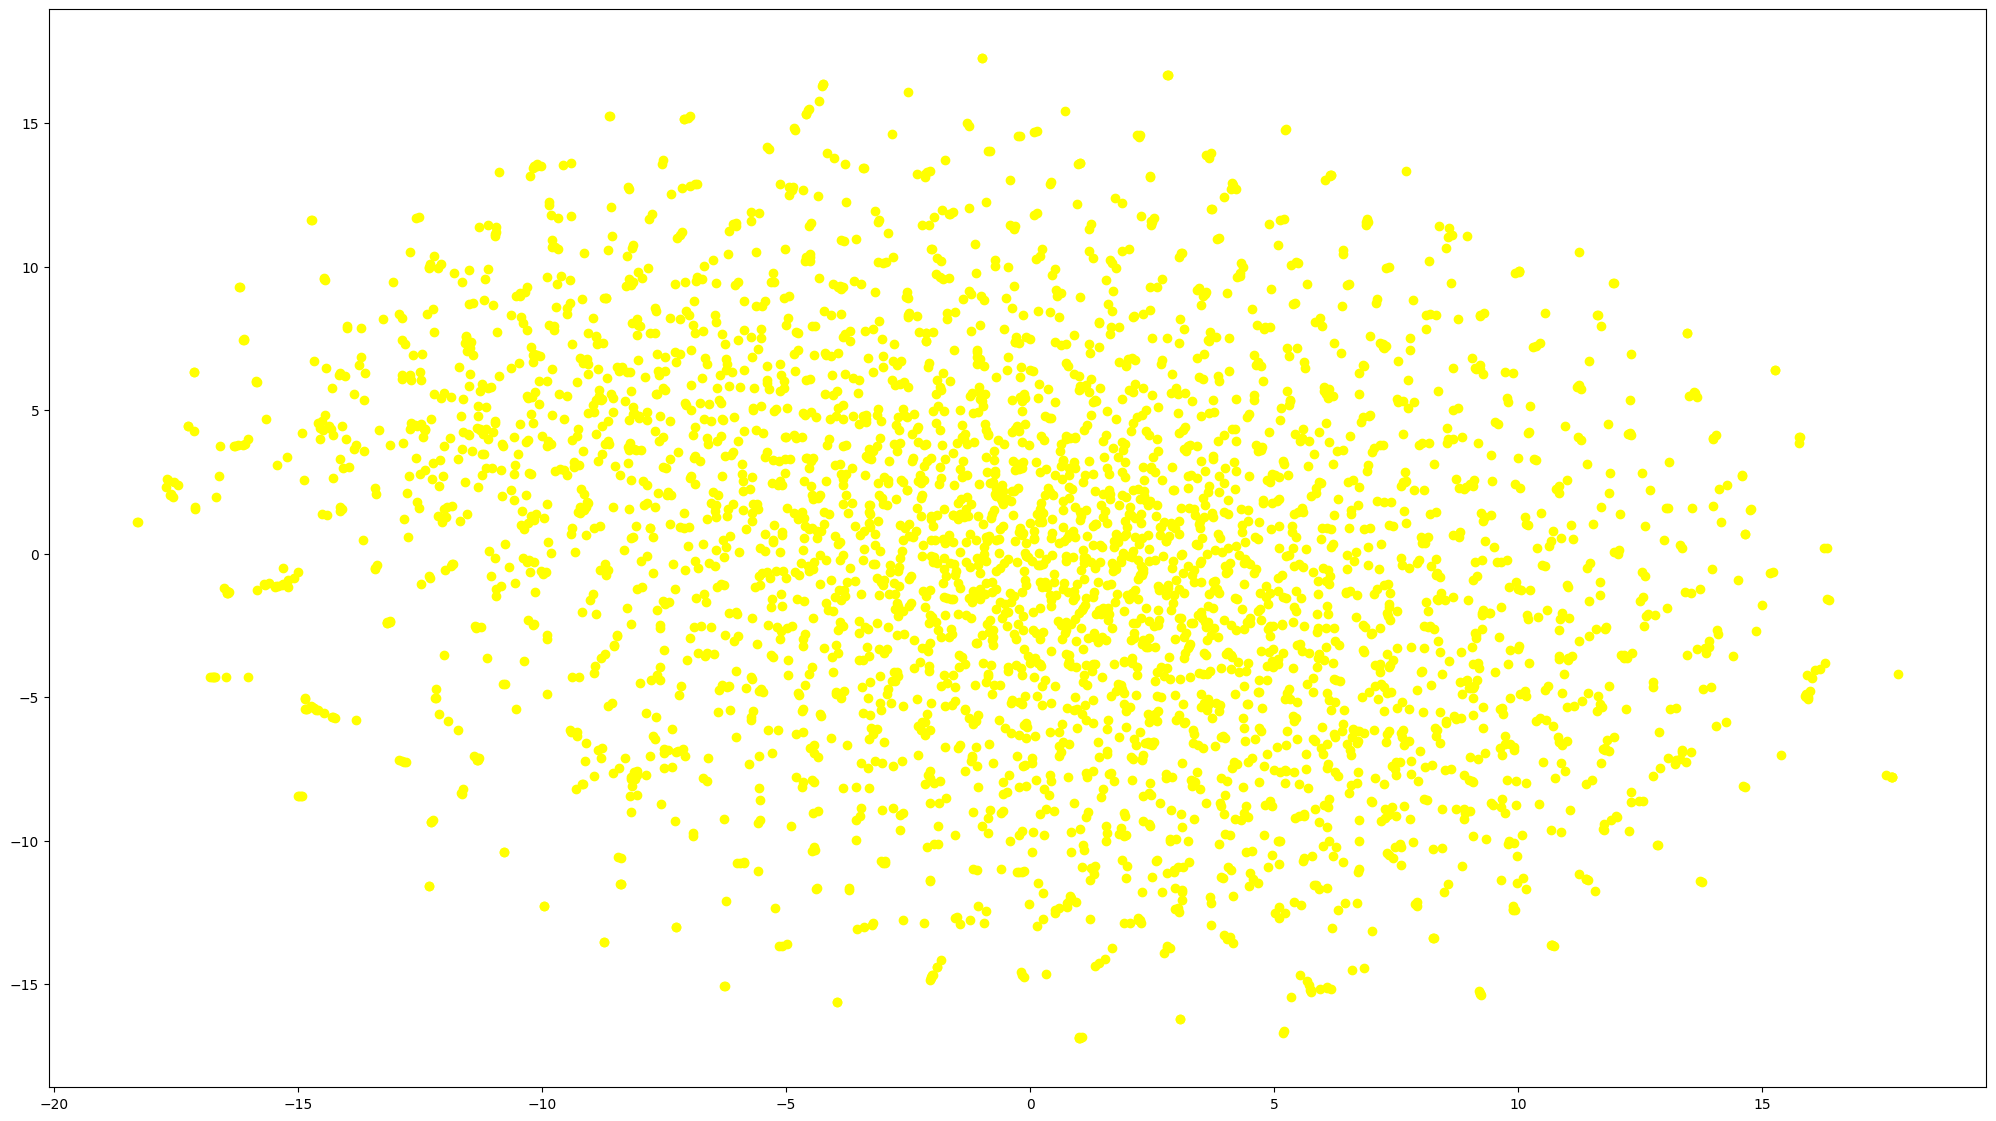

In [42]:
model = SVD()
model.fit(traindf)
# Item embeddings
item_embeddings = model.qi
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(item_embeddings)
plt.figure(figsize=(25, 14))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],color='yellow')
plt.show()

--The data set displays a circular pattern, with related movies being closer to one another.

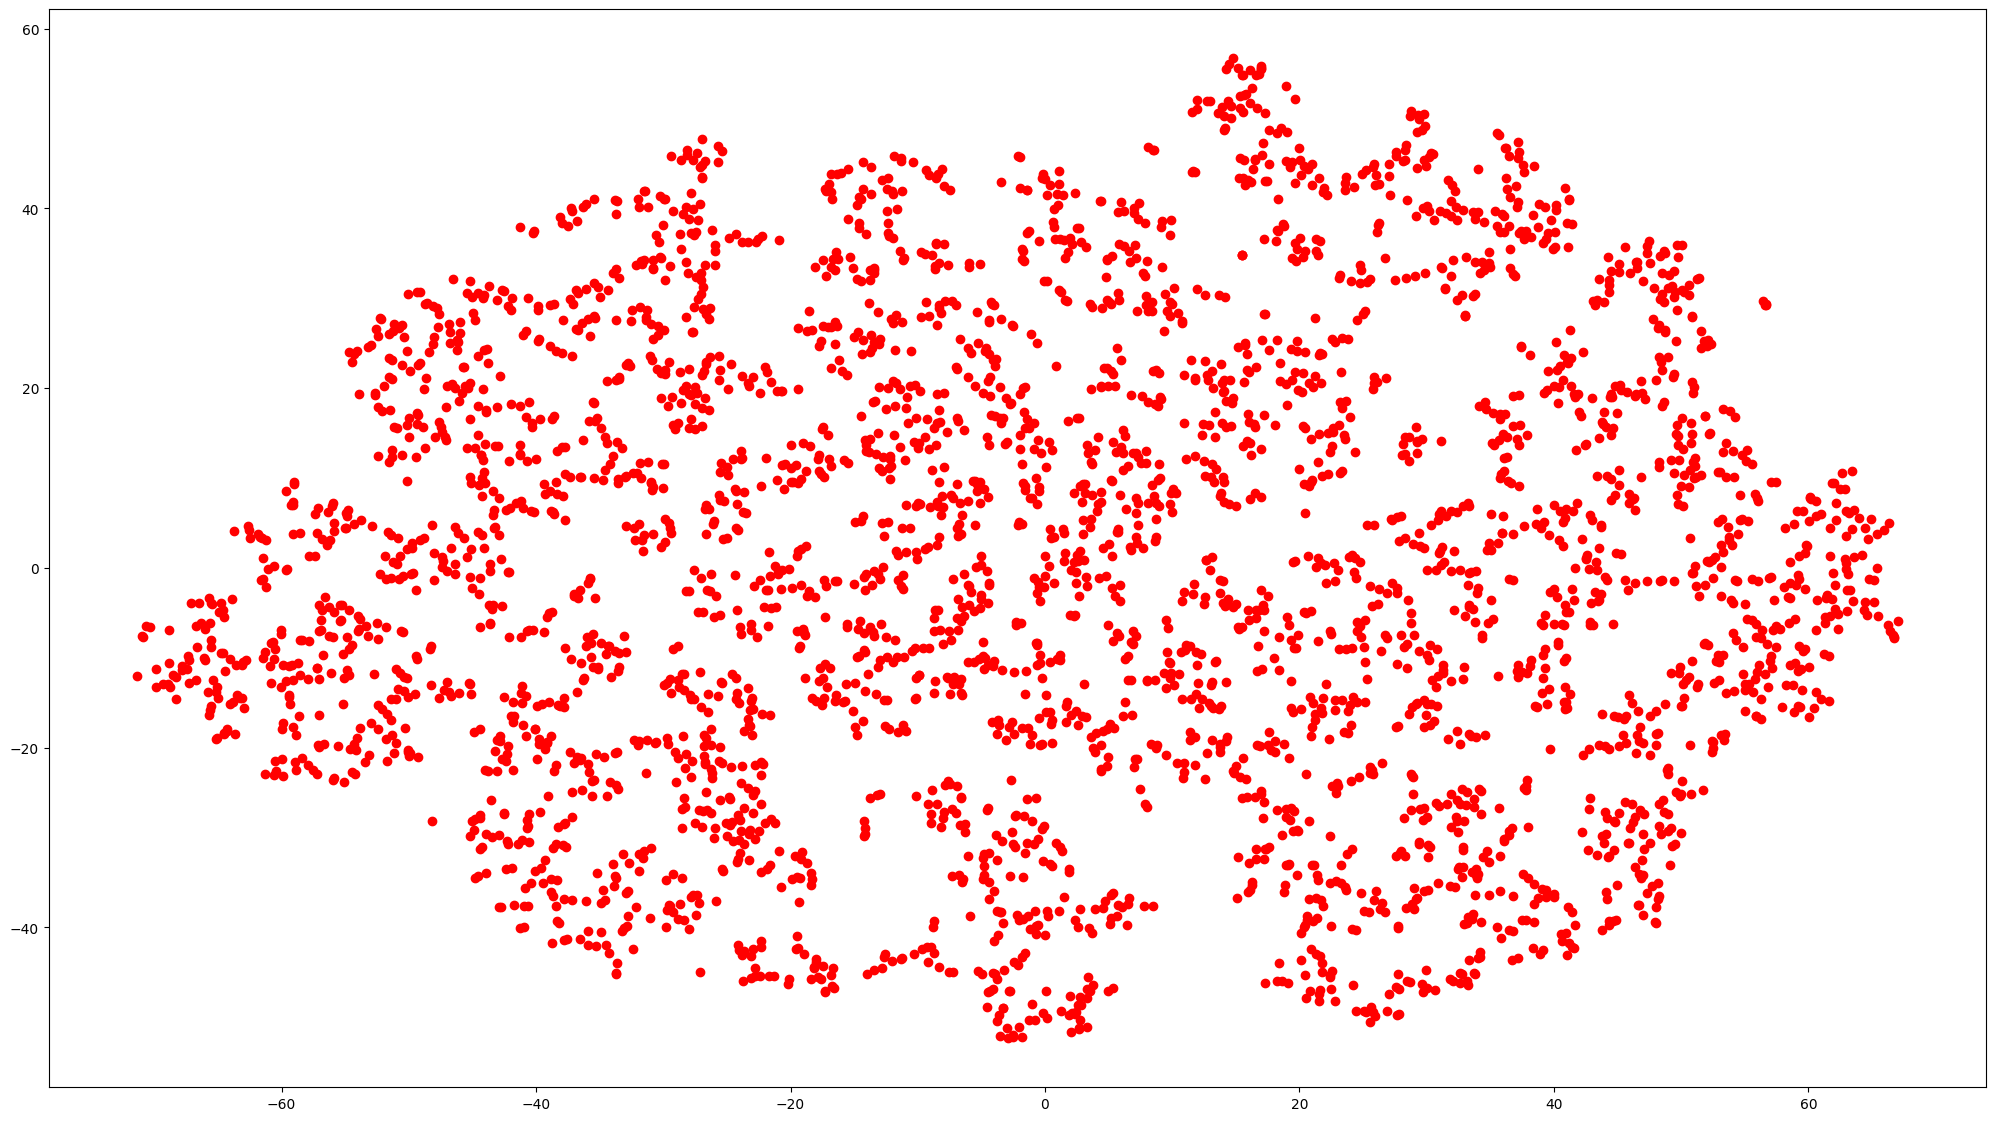

In [43]:
model = SVD(n_factors = 4)
model.fit(traindf)
# Example with item embeddings
item_embeddings = model.qi
tsne = TSNE(n_components = 2, random_state = 0)
embeddings_2d = tsne.fit_transform(item_embeddings)
# Plot
plt.figure(figsize = (25, 14))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],color='red')
plt.show()

Some cluster development is visible in embeddings with factors = 4.

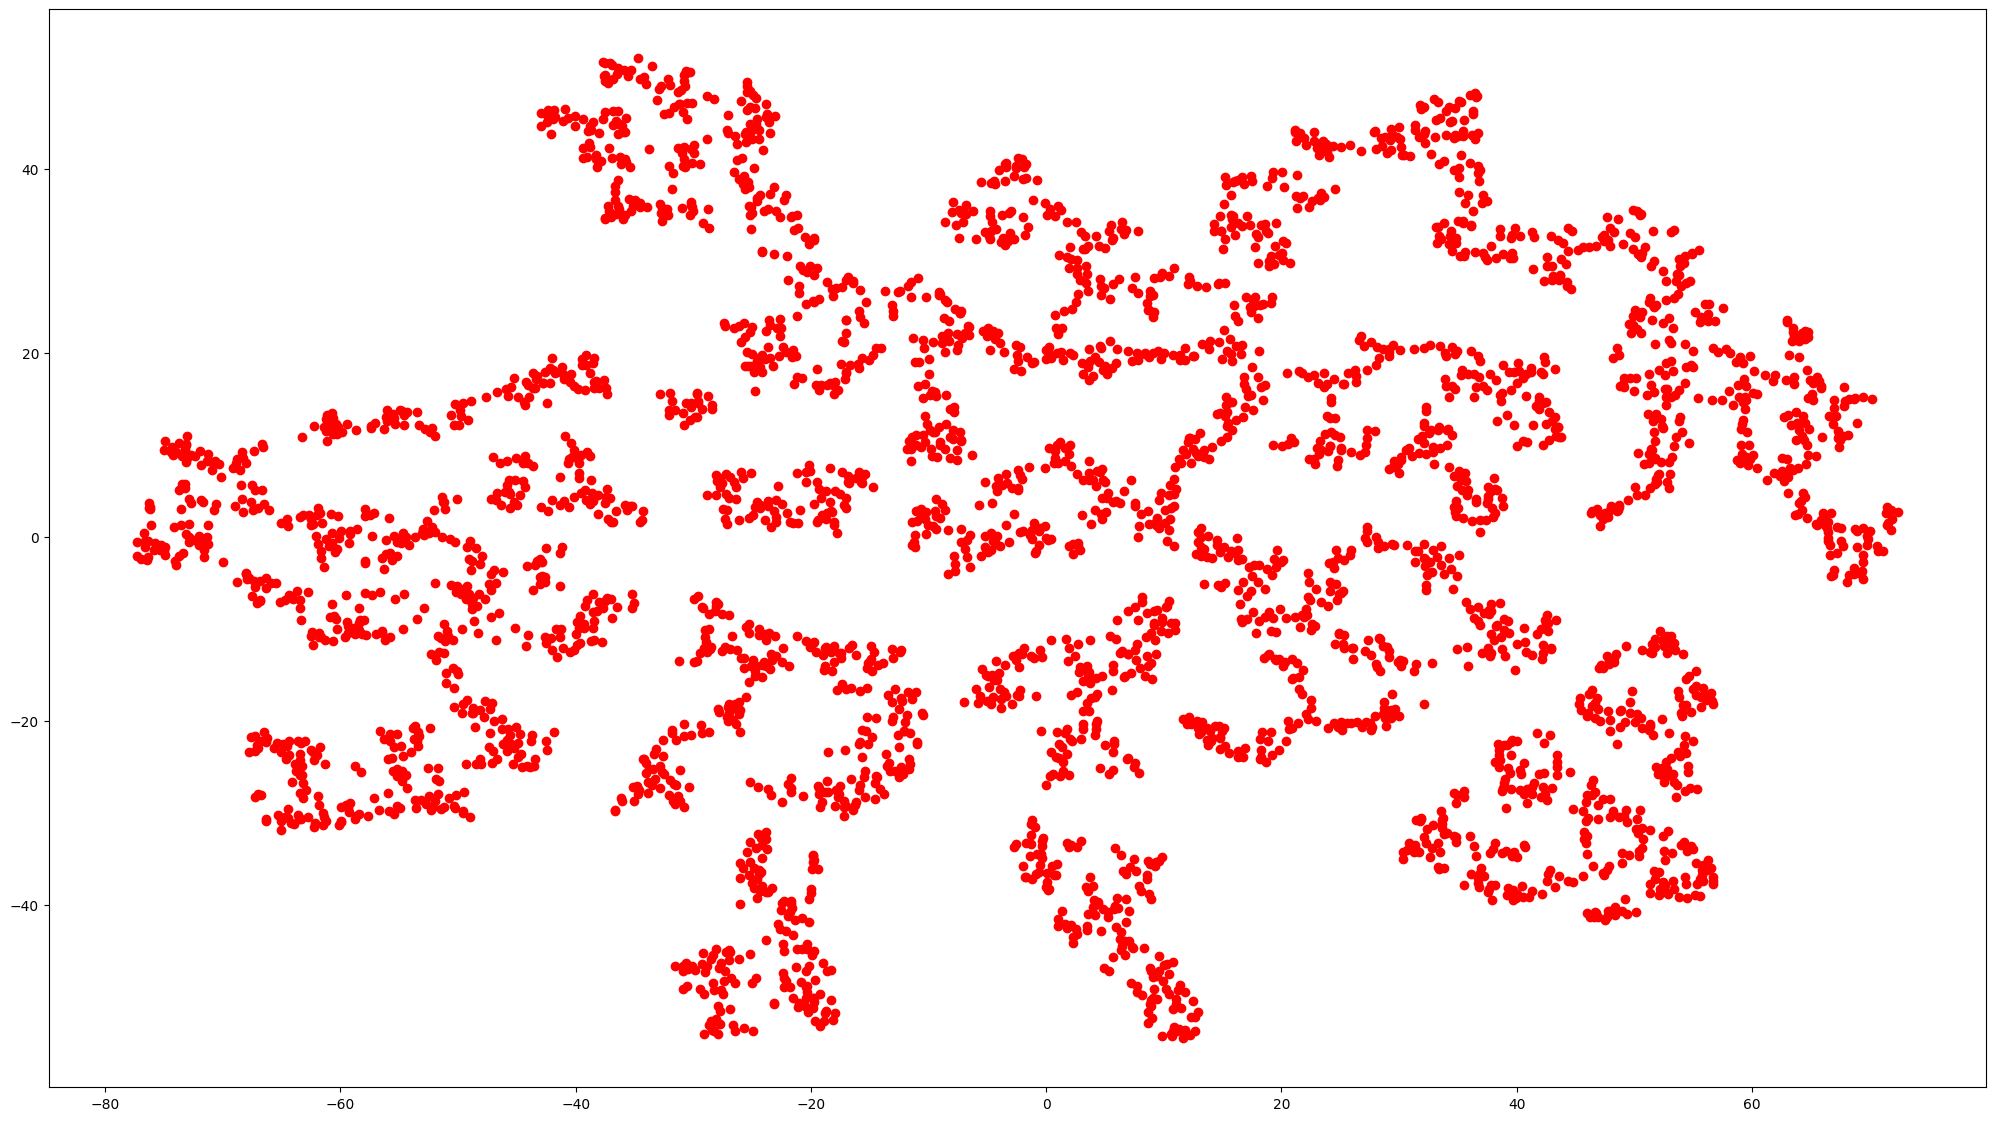

In [44]:
model = SVD(n_factors = 2)
model.fit(traindf)
# Example with item embeddings
item_embeddings = model.qi
tsne = TSNE(n_components = 2, random_state = 0)
embeddings_2d = tsne.fit_transform(item_embeddings)
# Plot
plt.figure(figsize = (25, 14))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],color='red')
plt.show()

Clusters are quite separable & visible in embeddings with factors = 2.